# **Cell clustering and Differential Expression (DE)**

---------------------------

**Motivation:**

Spermatogenesis goes through different stages, starting from *SpermatogoniaA* cells, going into clonal expansion while keeping cells connected through cytoplasmic bridges (*SpermatogoniaB*), and then continuing with the meiotic process (*Spermatocites I and II*). Finally, cells become *Round spermatids*, which then elongate to become *Elongated spermatids and sperm*.

![](https://raw.githubusercontent.com/hds-sandbox/scRNASeq_course/main/develop/python/img/spermatogenesis.png)

Detecting those cell types is essential to answer biological questions such as 
- which genes are most expressed for each cell type (beyond well known ones)?
- in which proportion is every cell type present?
- are there unknown cell types that I can identify?

---------------------------

**Learning objectives:**
- Identify potential cell clusters by visualizing marker genes on the UMAP plot
- Understanding and applying differential gene expression analysis to verify cluster identities
- Performing an analysis of subclusters in the dataset
----------------
**Execution time: 45-60 minutes**

---------------

***Import packages***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad

plt.rcParams['figure.figsize']=(6,6) #rescale figures

Read the data integrated with `glmpca` and `bbknn`

In [2]:
sample = sc.read('../../Data/notebooks_data/sample_123.filt.norm.red.h5ad')

Only considering the two last: ['.red', '.h5ad'].
Only considering the two last: ['.red', '.h5ad'].


## Identification through marker genes

we try to identify clusters of cells by looking at the expression of relevant marker genes. This requires a previous biological knowledge of those cell types, such that we can input the markers. Below, we define a dectionary, where for each cell type we define a list of markers. Then we will plot every list of markers on the UMAP plot

In [3]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2','PRM3','AKAP4'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD14']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

#remove markers missing in the dataset
for i in markers:
    markers[i] = np.intersect1d(markers[i], sample.var_names)

We can see how many markers easily identify groups of cells by plotting the expression

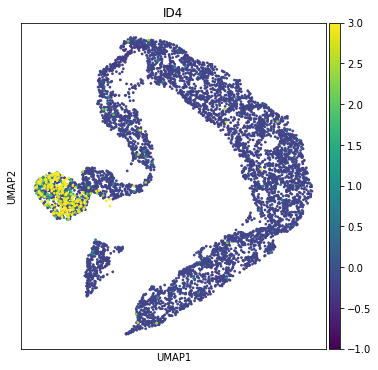

In [4]:
sc.plotting.umap(sample, color=markers['SpermatogoniaA'], vmin=-1, vmax=3, s=30)

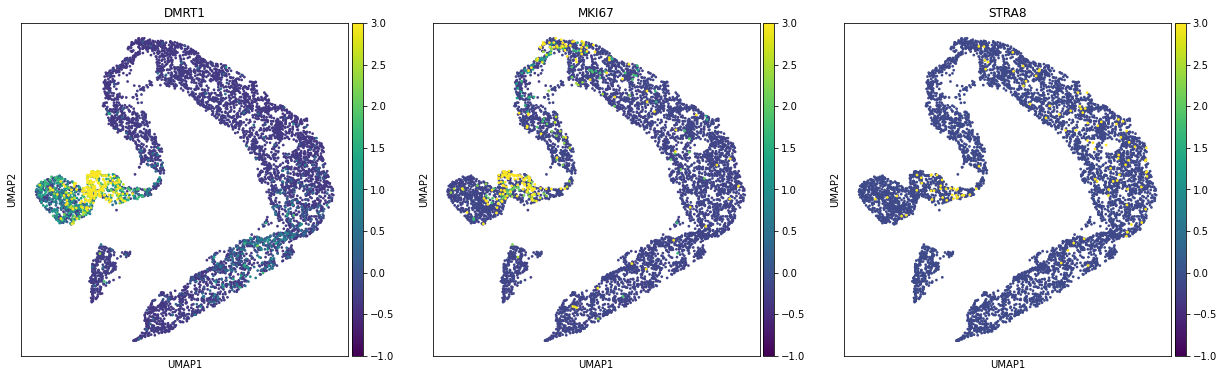

In [5]:
sc.plotting.umap(sample, color=markers['SpermatogoniaB'], vmin=-1, vmax=3, s=30)

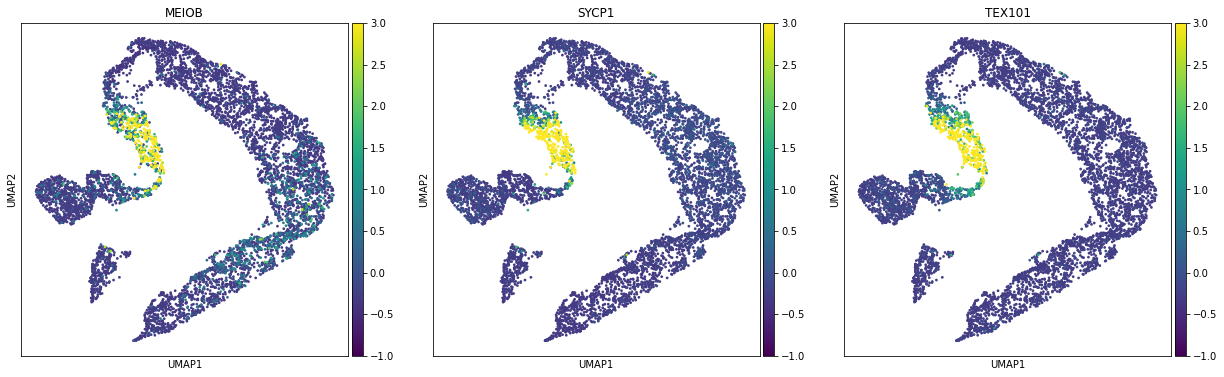

In [6]:
sc.plotting.umap(sample, color=markers['SpermatocytesI'], vmin=-1, vmax=3, s=30)

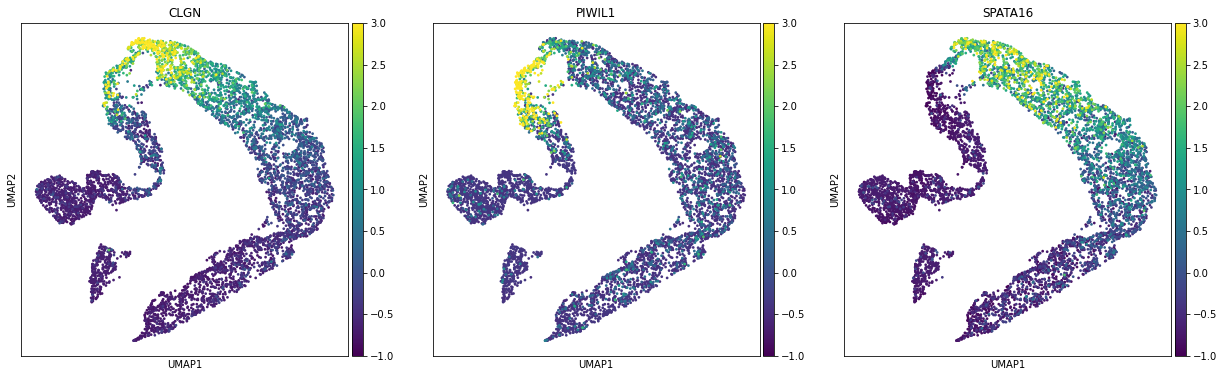

In [7]:
sc.plotting.umap(sample, color=markers['SpermatocytesII'], vmin=-1, vmax=3, s=30)

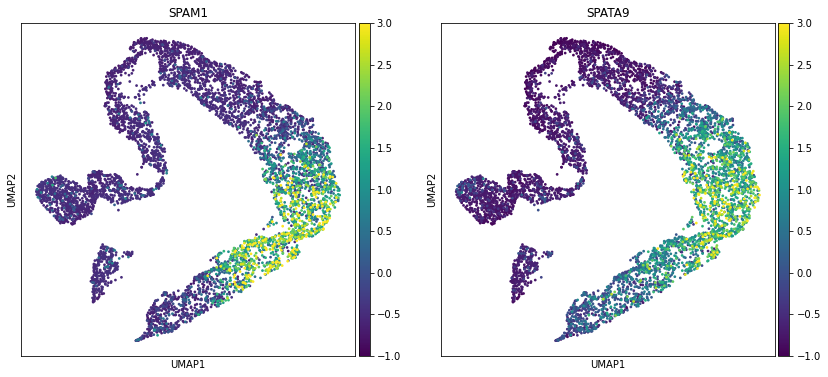

In [8]:
sc.plotting.umap(sample, color=markers['Round.Spt'], vmin=-1, vmax=3, s=30)

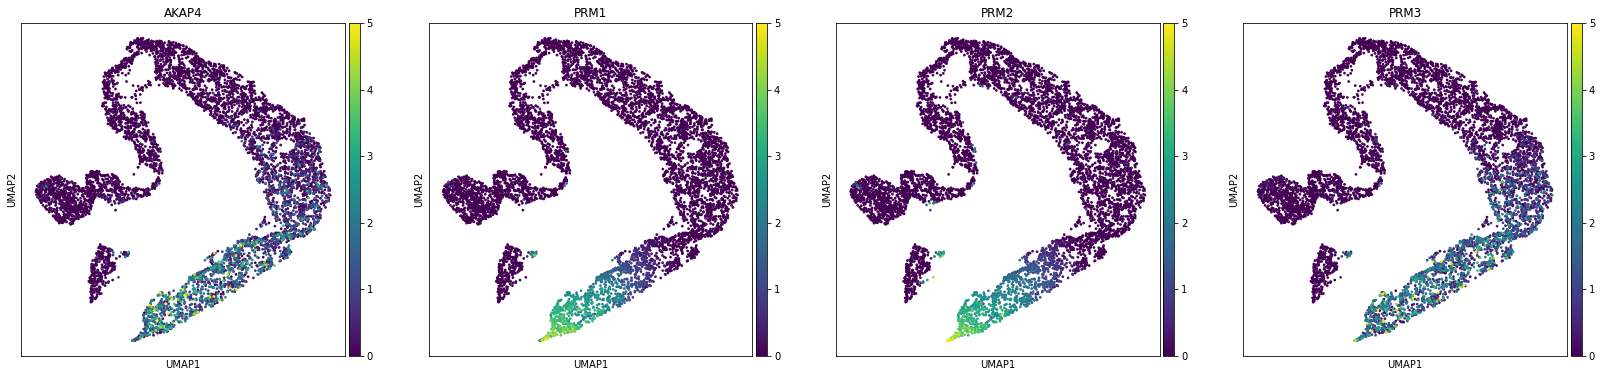

In [9]:
sc.plotting.umap(sample, color=markers['Elong.Spt'], vmin=0, vmax=5, s=30)

Sertoli are often not possible to identify. They are big in size, meaning they are often not isolated successfully. Many of their markers are in common with other somatic cells. Also, their function as nurse cells for germ cells of the testis means that their marker genes are also expressed. We can see that CTSL is expressed in some germ cells, but not in other clusters, while VIM is expressed in a likely somatic cluster (but it is common to other somatic cell types)

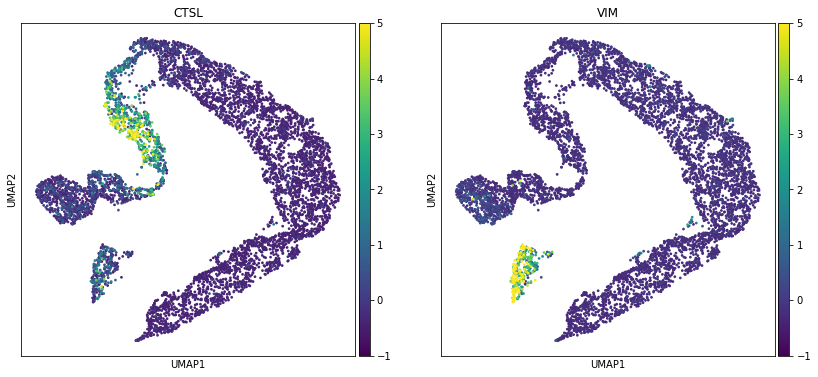

In [10]:
sc.plotting.umap(sample, color=markers['Sertoli'], vmin=-1, vmax=5, s=30)

Macrophage cells seem to be absent

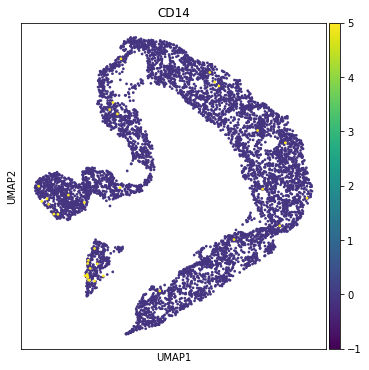

In [11]:
sc.plotting.umap(sample, color=markers['Macroph'], vmin=-1, vmax=5, s=30)

There is a little endothelial cluster

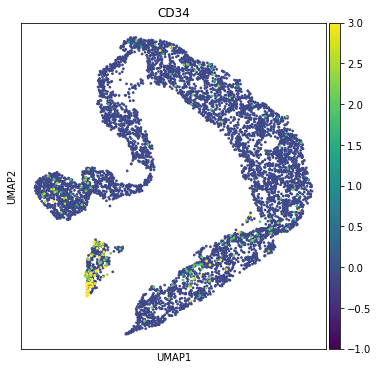

In [12]:
sc.plotting.umap(sample, color=markers['Endothelial'], vmin=-1, vmax=3, s=30)

and also a myoid cluster

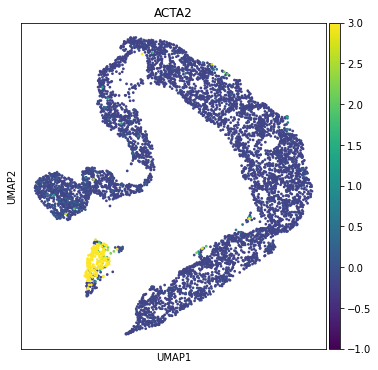

In [13]:
sc.plotting.umap(sample, color=markers['Myoid'], vmin=-1, vmax=3, s=30)

Leydig cells are likely to be missing as well

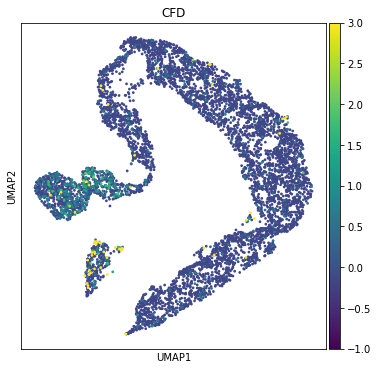

In [14]:
sc.plotting.umap(sample, color=markers['Leydig'], vmin=-1, vmax=3, s=30)

Now we create some clusters, and try to get the same division we saw by plotting markers. We can tune the number of clusters by changing the `resolution` parameter. We will be able to give the same name to more clusters, so it is fine to create a fine-grained clustering.

In [15]:
sc.tl.leiden(sample, resolution=.3, random_state=12345)

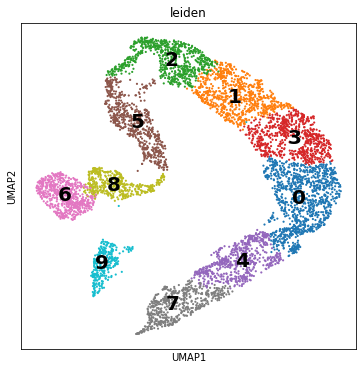

In [16]:
sc.plotting.umap(sample, color=['leiden'], legend_loc='on data', legend_fontsize=20)

Write the names in the dictionary `new_names`. You should be able to give a name for each cell type. Below is an example, but the names are not in the right position. If there is more than one cluster with same cell type, just write the name followed by a dot `.` and a number. For example, by writing for example `.1` and `.2` at the end of the names. We will remove the numbers afterwords.

In [42]:
clusters = pd.Categorical(sample.obs['leiden'])

In [43]:
new_names = {
    '0':'RoundSpermatids.2',
    '1':'SpermatocitesII.2',
    '2':'SpermatocitesII.1',
    '3':'RoundSpermatids.1',
    '4':'RoundSpermatids.3',
    '5':'SpermatocitesI',
    '6':'SpermatogoniaA',
    '7':'ElongSpermatids',
    '8':'SpermatogoniaB',
    '9':'Somatic',
}

we apply the new names

In [44]:
clusters=clusters.rename_categories(new_names)

we remove the numbers from same cell types

In [45]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

save the clusters in the sample and plot the new ones

In [46]:
sample.obs['clusters']=clusters.copy()

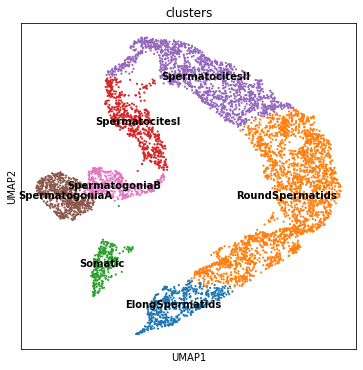

In [47]:
sc.plotting.umap(sample, color=['clusters'], legend_loc='on data')

We can look at markers in a heatmap or a dotplot

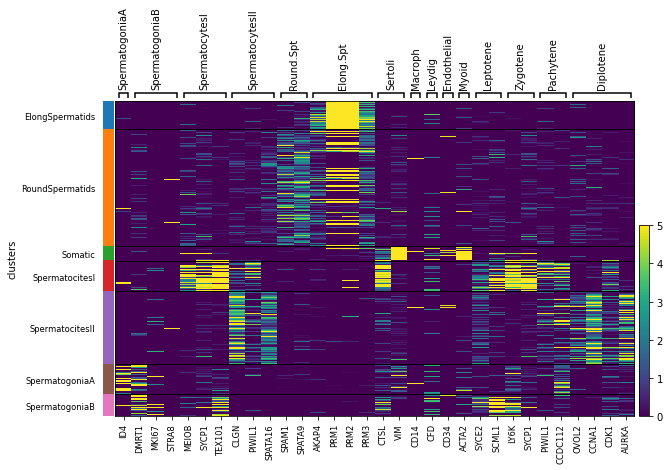

In [60]:
sc.pl.heatmap(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=5, layer='norm_sct')

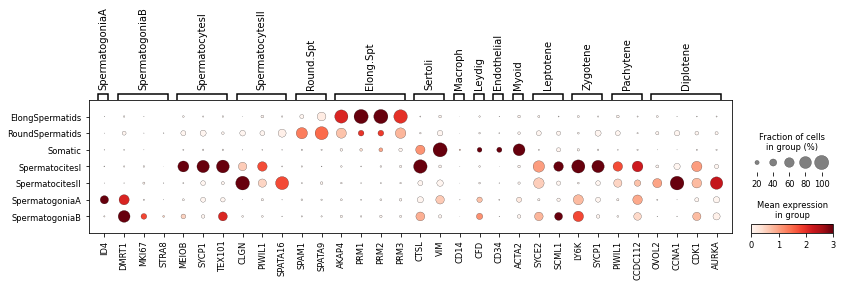

In [61]:
sc.pl.dotplot(sample, 
              groupby='clusters', 
              var_names=markers,
              vmin=0, vmax=3, layer='norm_sct')

In [62]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.h5ad')

## Differential Expression (DE) analysis

We can do differential expression (DE) analysis to double check which genes are differentially expressed in each cluster. A gene is differentially expressed in a cluster when its expression in the cells of that cluster is statistically bigger than in all other cells. This is verified through a statistical test. 

Together with the gene names we also get p-values from the test, and a factor (`log-fold change`) telling the magnitude of how much the expression is larger than in other cells.

In [63]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

Apply the differential expression tool on the clusters for the top ten genes of each cluster. Save the results in `.uns[DE_clusters]`

In [64]:
sc.tl.rank_genes_groups(sample, groupby='clusters', key_added='DE_clusters', 
                        use_raw=False, n_genes=10, method='wilcoxon')

Access the list of names

In [65]:
pd.DataFrame(sample.uns['DE_clusters']['names'])

ElongSpermatids RoundSpermatids Somatic SpermatocitesI SpermatocitesII  \
0            PRM1          ERICH2   RPL10        C5orf58      AL133499.1   
1            PRM2          SPACA3     VIM        HORMAD1          CAVIN3   
2            TNP1         FAM209B  TMSB4X          CALM2            LDHC   
3       LINC01921          ACTRT3   RPL41          TEX30          CCDC42   
4           LELP1           LYZL2     B2M          GIHCG           CCNA1   
5            GLUL         FAM209A   CALD1           TPTE           SNRPC   
6            ODF2           ACRV1  EEF1A1          SYCP3            GYG1   
7        C10orf62          SPACA4    MYL6        C5orf47          PPP3R2   
8      AC010255.3           TEX38  MALAT1         YEATS4           TBPL1   
9          GAPDHS          FNDC11  RPL13A          STMN1         ZMYND10   

  SpermatogoniaA SpermatogoniaB  
0           CCNI           PTMA  
1          RPS12          HMGB1  
2         DNAJB6          TKTL1  
3          FKBP8          CIRBP  
4          RPS19           SMC3  
5           RPSA           NASP  
6         TUBA1B         GAGE2A  
7         ZNF428          CENPH  
8        HNRNPDL            VCX  
9         RPL18A          RNPS1

Access the table including p-values (with suffix `_P` in each column) and log-fold change (with suffix `_L` in each column)

In [66]:
result = sample.uns['DE_clusters']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
X

ElongSpermatids_N  ElongSpermatids_P  ElongSpermatids_L RoundSpermatids_N  \
0              PRM1       0.000000e+00           5.424479            ERICH2   
1              PRM2       0.000000e+00           5.209908            SPACA3   
2              TNP1       0.000000e+00           5.488156           FAM209B   
3         LINC01921       0.000000e+00           4.946648            ACTRT3   
4             LELP1       0.000000e+00           3.589862             LYZL2   
5              GLUL      7.237615e-307           3.706899           FAM209A   
6              ODF2      3.064374e-299           1.973805             ACRV1   
7          C10orf62      4.782059e-298           3.640351            SPACA4   
8        AC010255.3      4.635726e-297           3.867987             TEX38   
9            GAPDHS      5.991587e-293           3.160353            FNDC11   

   RoundSpermatids_P  RoundSpermatids_L Somatic_N      Somatic_P  Somatic_L  \
0                0.0           3.723197     RPL10  1.165366e-182   6.021513   
1                0.0           3.749119       VIM  1.097107e-179   5.835199   
2                0.0           4.002403    TMSB4X  1.097107e-179   7.049301   
3                0.0           3.622047     RPL41  1.097107e-179   2.986831   
4                0.0           3.953832       B2M  1.136422e-179   6.462081   
5                0.0           3.994679     CALD1  6.194870e-179   6.696813   
6                0.0           4.234857    EEF1A1  6.194870e-179   3.107394   
7                0.0           3.867763      MYL6  1.721456e-178   4.102656   
8                0.0           3.183808    MALAT1  5.626453e-178   4.390934   
9                0.0           3.231125    RPL13A  1.387367e-177   3.765173   

  SpermatocitesI_N  ...  SpermatocitesI_L  SpermatocitesII_N  \
0          C5orf58  ...          4.528355         AL133499.1   
1          HORMAD1  ...          3.864654             CAVIN3   
2            CALM2  ...          3.609717               LDHC   
3            TEX30  ...          2.524987             CCDC42   
4            GIHCG  ...          4.371835              CCNA1   
5             TPTE  ...          5.264680              SNRPC   
6            SYCP3  ...          4.199960               GYG1   
7          C5orf47  ...          3.363791             PPP3R2   
8           YEATS4  ...          3.971394              TBPL1   
9            STMN1  ...          1.983654            ZMYND10   

  SpermatocitesII_P  SpermatocitesII_L  SpermatogoniaA_N SpermatogoniaA_P  \
0               0.0           4.033264              CCNI              0.0   
1               0.0           3.786669             RPS12              0.0   
2               0.0           2.834788            DNAJB6              0.0   
3               0.0           3.629347             FKBP8              0.0   
4               0.0           3.463029             RPS19              0.0   
5               0.0           2.780885              RPSA              0.0   
6               0.0           2.565860            TUBA1B              0.0   
7               0.0           2.838620            ZNF428              0.0   
8               0.0           2.577030           HNRNPDL              0.0   
9               0.0           2.981664            RPL18A              0.0   

   SpermatogoniaA_L  SpermatogoniaB_N SpermatogoniaB_P  SpermatogoniaB_L  
0          5.040952              PTMA    4.137813e-246          4.634084  
1          3.314525             HMGB1    4.461523e-244          4.077361  
2          4.057697             TKTL1    1.357135e-227          4.654473  
3          2.260040             CIRBP    3.126263e-223          4.027591  
4          3.515247              SMC3    3.942919e-219          4.313029  
5          4.090869              NASP    6.241038e-212          3.694299  
6          3.110117            GAGE2A    2.813535e-210          5.291031  
7          3.869403             CENPH    1.912928e-208          3.628259  
8          3.780063               

We can easily save the table in csv format. This can be opened in Excel.

In [67]:
!mkdir -p ../../Data/results

In [68]:
X.to_csv('../../Data/results/diff_expression_clusters.csv', header=True, index=False)

## Subclustering the data

We find subclusters of cells using markers for cell types that are found between late spermatogonia and spermatocites.

In [69]:
#Clusters to be subsetted
SUBGROUPS = ['SpermatogoniaB','SpermatocitesI','SpermatocitesII'] 

In [70]:
#Markers for the processes involved in late spermatogonia and spermatocites
markers['Leptotene'] = ['SYCE2','SCML1']
markers['Zygotene'] = ['LY6K', 'SYCP1']
markers['Pachytene'] = ['PIWIL1','CCDC112']
markers['Diplotene'] = ['OVOL2','CCNA1', 'CDK1','AURKA']

Let's look at the markers plottes only over the cells of the clusters `SpermatogoniaB`, `SpermatocitesI` and `SpermatocitesII`

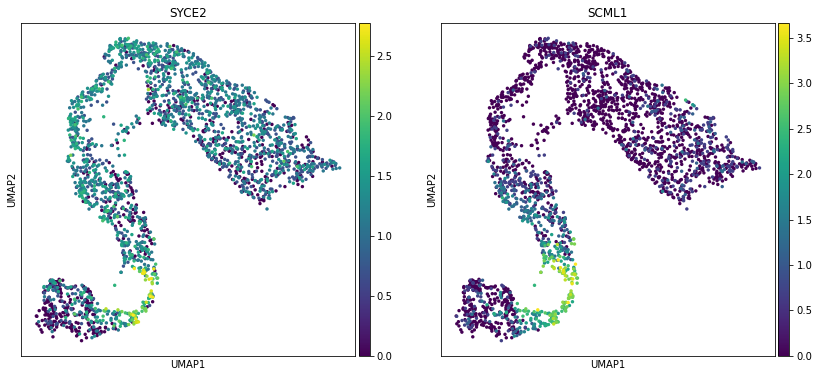

In [71]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Leptotene'])

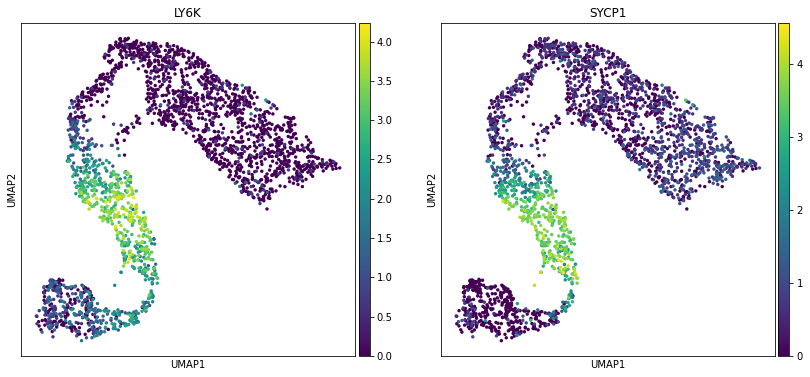

In [72]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Zygotene'])

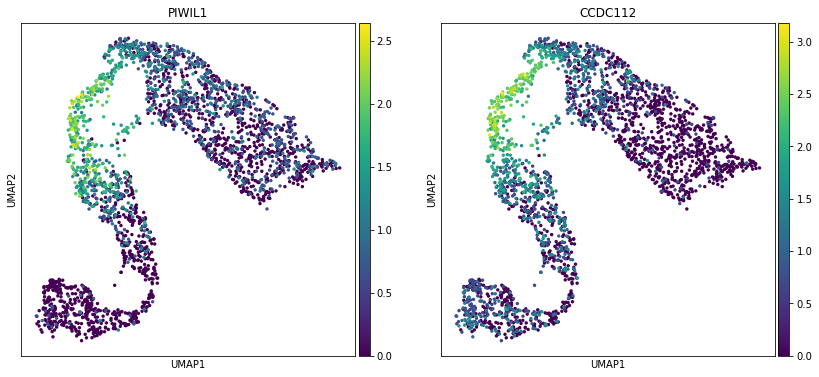

In [73]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Pachytene'])

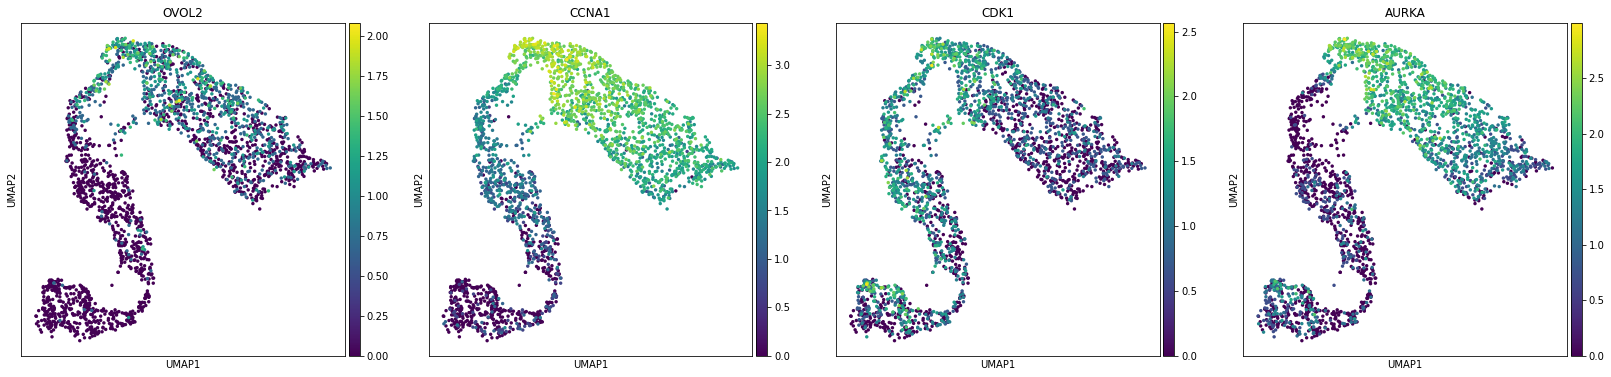

In [74]:
sc.pl.umap( sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=markers['Diplotene'])

We want to create new clusters in our dataset by starting from the old clustering. To do this we use the option `restrict_to`, where we write the name of the old clustering, and the name of which clusters we want to subset. Try to tune the resolution to have a proper number of clusters to rename.

In [121]:
sc.tl.leiden(sample, resolution=.4, key_added='clusters_spc',
            restrict_to=('clusters', SUBGROUPS),
            random_state=12345)

Let's look at the new clustering of `spermatogoniaB` and `spermatocites I/II`

Trying to set attribute `.uns` of view, copying.


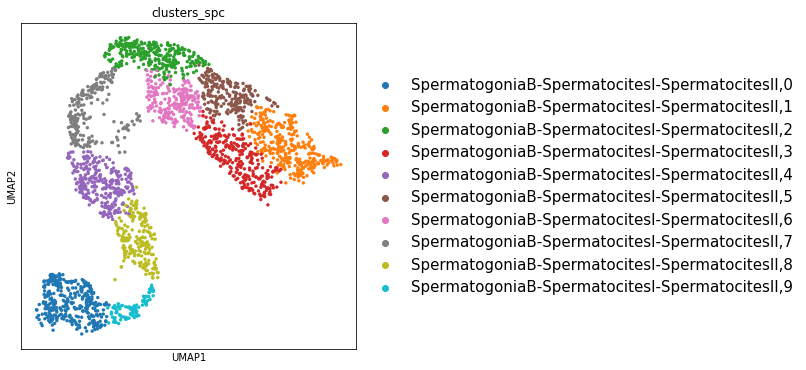

In [122]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_fontsize=15)

Names are very long. We keep only the numbers at the end

In [123]:
clusters = sample.obs['clusters_spc']
cluster_array = np.array(clusters)
split_array = [ i.split(',')[1] if ',' in i else i for i in cluster_array]
clusters = pd.Categorical(split_array)
sample.obs['clusters_spc']=clusters.copy()

Trying to set attribute `.uns` of view, copying.


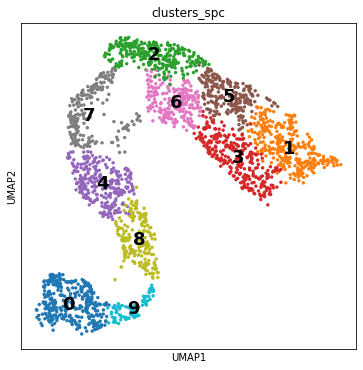

In [124]:
sc.pl.umap(sample[ [i in SUBGROUPS for i in sample.obs['clusters']] ], 
           color=['clusters_spc'], legend_loc='on data', legend_fontsize=18)

Before renaming, we also want to look at the differentially expressed genes. We should be able to find at least some of the markers used in the plots. However, it can be that those do not appear because there are many other coexpressed genes with high expression values.

In [125]:
sample.X = sample.layers['umi_sct'].copy()
sc.pp.log1p(sample)

In [126]:
sc.tl.rank_genes_groups(sample, groupby='clusters_spc', key_added='DE_clusters_spc',
                        use_raw=False, n_genes=20, method='wilcoxon')

We can find some of the marker genes. For example `SCML1` for leptotene cells, `SYCP1` and `LY6K` for zygotene, `CCDC112` and `PIWIL1` for pachitene, `CCNA1` and `AURKA` for zygotene. 

In [127]:
pd.DataFrame(sample.uns['DE_clusters_spc']['names'])

0         1           2           3           4           5  \
0       PTMA    SLC51B     CIAPIN1       SNRPC        TPTE        GYG1   
1      HMGB1    PAIP2B       CCNA1       TBPL1     C5orf58       TBPL1   
2    TRMT112     H1FOO      ASRGL1         UBB      TMEM99       ISOC2   
3       CFL1    CDRT15        CLGN      UQCR10      SPATA8      CAVIN3   
4      TKTL1    GTF2A2      PPP3R2    CATSPERZ       GIHCG       SNRPC   
5      CIRBP    ETFRF1  AL133499.1      FBXO25  AC044839.1       CCNA1   
6      PRAME  C9orf116     NDUFAF3      CDRT15       TDRG1        LDHC   
7     GAGE2A     ZNRD1        LDHC  AL133499.1       H2AFZ     ZC2HC1C   
8       APRT      CT66      MRPL34   MCHR2-AS1        CKLF      CCDC42   
9      RNPS1  C1orf189      CAVIN3        CT66       CALM2         PBK   
10  PAFAH1B3    CCDC42       AURKA       CMTM2        LY6K       REXO5   
11      RBM3   CCDC110        LYAR      ETFRF1       H3F3B  AL133499.1   
12      RPS2    ROPN1L        RAE1      CCDC42     ARL6IP1      MRPL34   
13      LSM2  C16orf95     ZMYND10       H2AFJ      PRSS21        RGCC   
14      LSM4    LRRC34        GYG1       TSACC     HORMAD1       CCNB2   
15     CCT6A     CCNB2       ISOC2      CAVIN3       STMN1       PTTG1   
16     PRDX5  C9orf135       COPRS      MRPS33        CTSL     ZMYND10   
17      PFN1      PIFO     ZC2HC1C       SNU13        TBCA       LRWD1   
18     YWHAE     TBPL1  AC002467.1       ISOC2      TEX101      TMIGD3   
19     PRDX1  C1orf158    TMPRSS12         PBK      KRBOX1       COPRS   

             6          7        8       9 ElongSpermatids RoundSpermatids  \
0   AL133499.1   C15orf48   TEX101     VCX            PRM1          ERICH2   
1         GYG1    CCDC112    SYCP1   CLSPN            PRM2          SPACA3   
2          UBB      CETN3  C5orf47   SCML1            TNP1         FAM209B   
3        COPRS       PHF7   ZCWPW1    SMC3       LINC01921          ACTRT3   
4       PPP3R2     COX7A2     LY6K   VCX3B           LELP1           LYZL2   
5      NDUFAF3     MGAT4D  SELENOT   TEX19            GLUL         FAM209A   
6      ZMYND10  STIM2-AS1    SYCP3   GINS2            ODF2           ACRV1   
7         LDHC     RPL39L     RHEB   SMC1B        C10orf62          SPACA4   
8        CCNA1      RNFT1  HORMAD1    CBX1      AC010255.3           TEX38   
9        SNRPC      GIHCG   FMR1NB    VCX2          GAPDHS          FNDC11   
10      SPINK2     PIWIL1  TMEM147   HMGB1           TSSK6          MS4A6E   
11        RAE1     CFAP53     NPC2   PAGE1         P3R3URF         TMEM270   
12       APH1B     CAPNS1  C5orf58   VPS29           HMGB4        C1orf185   
13        LYAR       ARL3     SMC3   SYCP3         DCUN1D1         SPATA46   
14       ISOC2    FAM174A  HSP90B1   DPEP3            OAZ3           TEX33   
15      CAVIN3    MORF4L1    EIF1B  ZCWPW1          SPATA3           TMCO2   
16      UQCR10      TERB2    TEX30   HMGB2           TEX37           SESN3   
17      MRPL34      GMCL2    SMC1B  PRSS21           TEX44          SPACA7   
18        CLGN     ADAM18    STMN1   TAF12           IQCF1           LYZL1   
19       H2AFJ       TYMS    TEX12   VCX3A          SH3RF2           NDRG3   

   Somatic SpermatogoniaA  
0    RPL10           CCNI  
1      VIM          RPS12  
2   TMSB4X         DNAJB6  
3    RPL41          FKBP8  
4      B2M          RPS19  
5    CALD1           RPSA  
6   EEF1A1         TUBA1B  
7     MYL6         ZNF428  
8   MALAT1        HNRNPDL  
9   RPL13A         RPL18A  
10     FTL         EEF1B2  
11    CD63          YWHAB  
12  TMSB10         LYPLA1  
13     MGP           RPS5  
14  RPL27A          EGFL7  
15   RPS4X          RPS21  
16  RPL10A          RPLP0  
17    RPS8       PAFAH1B3  
18   RPL39          GAPDH  
19    BEX3           FTH1

We can again look at p-values and log-fold changes

In [128]:
result = sample.uns['DE_clusters_spc']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

and save the table

In [129]:
X.to_csv('../../Data/results/diff_expression_subclusters.csv', header=True, index=False)

We can look at only the columns of a cluster from the large table so it is more readable

In [130]:
X[ ['7_N','7_L','7_P'] ]

7_N       7_L            7_P
0    C15orf48  3.345649  2.622325e-128
1     CCDC112  4.729542  1.223015e-124
2       CETN3  4.482161  1.380457e-124
3        PHF7  1.827035  2.073073e-124
4      COX7A2  1.712644  8.065361e-124
5      MGAT4D  4.345105  2.583717e-123
6   STIM2-AS1  4.371103  7.843116e-121
7      RPL39L  2.112728  1.423343e-119
8       RNFT1  3.232861  9.407704e-119
9       GIHCG  4.316514  1.840229e-118
10     PIWIL1  4.078243  1.135467e-117
11     CFAP53  2.128810  2.953196e-116
12     CAPNS1  2.812432  5.598749e-116
13       ARL3  2.955955  2.353447e-115
14    FAM174A  3.391331  5.456074e-114
15    MORF4L1  1.856730  7.600824e-114
16      TERB2  3.645232  3.701972e-113
17      GMCL2  4.118266  4.788679e-113
18     ADAM18  3.235833  5.305527e-113
19       TYMS  3.357929  5.367116e-112

We rename the new clusters. Write the names in the dictionary. Some of the clusters might still be `SpermatogoniaB` or `SpermatocitesII` as before.

In [131]:
clusters = pd.Categorical(sample.obs['clusters_spc'])

In [132]:
new_names = {
    '0':'SpermatogoniaB',
    '1':'SpermatocitesII.2',
    '2':'Diplotene.1',
    '3':'SpermatocitesII.1',
    '4':'Zygotene.1',
    '5':'Diplotene.3',
    '6':'Diplotene.2',
    '7':'Pachytene',
    '8':'Zygotene.2',
    '9':'Leptotene'
}

In [133]:
clusters=clusters.rename_categories(new_names)

In [134]:
cluster_array = np.array(clusters)
split_array = [ i.split('.')[0] for i in cluster_array ]
clusters = pd.Categorical(split_array)

In [135]:
sample.obs['clusters_spc']=clusters.copy()

Just a plot of the two clustering side by side

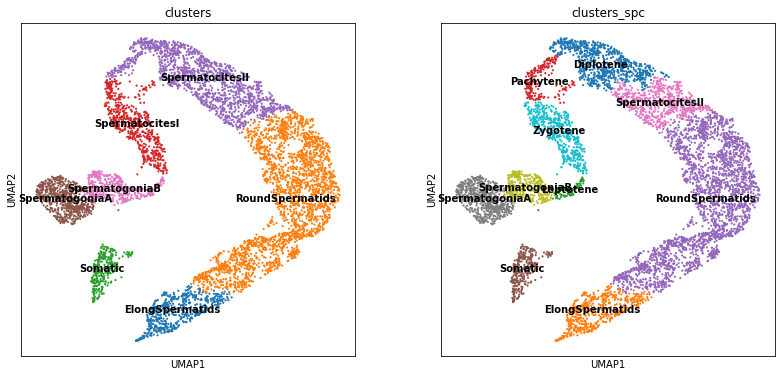

In [136]:
sc.plotting.umap(sample, color=['clusters','clusters_spc'], legend_loc='on data')

It isn't really clear how to rename clusters in somatic cells. We let them be called `somatic` without further specification

You can plot the correlation matrix of the clusters with a dendrogram tree on the left side. Note how round and elongated spermatids are largely separated from the rest of the data. Spermatogonias are very similar to each other and could maybe reduced into a single cluster. 

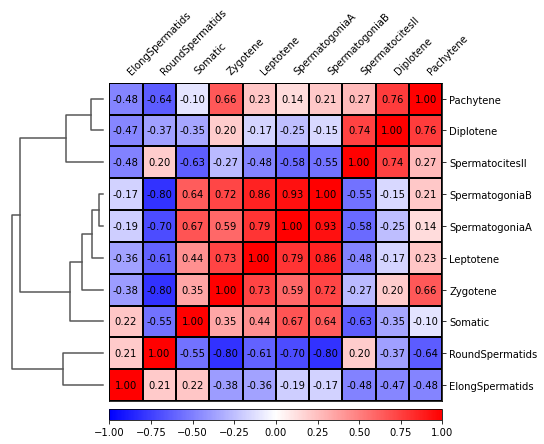

In [142]:
sc.pl.correlation_matrix(sample, groupby='clusters_spc', 
                         show_correlation_numbers=True)

Look at the proportion of each cell type in the data

In [144]:
#number of cells
sample.obs['clusters_spc'].value_counts()

RoundSpermatids    2390
Diplotene           759
SpermatogoniaA      626
SpermatocitesII     621
ElongSpermatids     564
Zygotene            512
SpermatogoniaB      345
Somatic             301
Pachytene           216
Leptotene            97
Name: clusters_spc, dtype: int64

In [145]:
#Percentage of cells
sample.obs['clusters_spc'].value_counts() / sample.shape[0] * 100

RoundSpermatids    37.163738
Diplotene          11.802208
SpermatogoniaA      9.734100
SpermatocitesII     9.656352
ElongSpermatids     8.770020
Zygotene            7.961437
SpermatogoniaB      5.364640
Somatic             4.680454
Pachytene           3.358731
Leptotene           1.508319
Name: clusters_spc, dtype: float64

finally, save the data

In [146]:
sample.write('../../Data/notebooks_data/sample_123.filt.norm.red.clst.2.h5ad')

## Wrapping up

We have been showing how to simply identify potential cell clusters. At least in this dataset, the cells change from one type to another in a continuous process, so such a hard clustering does not completely reflect biological reality. However, it is a good approximation, as it is illustrated by the differentially expressed genes we could check in each cluster.
We introduced how to perform differential expression, and what are the useful values that we get from it (p-value of the test, magnitude of the gene expression compared to all other clusters). Finally, we subsetted the data into a more fine grained cell identification.